# Pesticide Optimization using Reinforcement Learning

This notebook demonstrates the application of various reinforcement learning algorithms to optimize pesticide usage in agriculture. The goal is to find an optimal policy that maintains crop health while minimizing environmental impact from pesticide use.

## Overview
- **Environment**: Agricultural setting with crop health, pest levels, and weather conditions
- **Actions**: Different pesticide dosage levels (0=None, 1=Low, 2=Medium, 3=High)
- **Goal**: Maximize crop yield while minimizing pesticide usage

## 1. Import Required Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import pandas as pd

## 2. Pesticide Environment

The environment simulates an agricultural setting where:
- **States**: (crop_health, pest_level, weather_condition)
- **Actions**: 0=No pesticide, 1=Low dose, 2=Medium dose, 3=High dose
- **Rewards**: Based on crop health, pest damage, and environmental costs

In [22]:
class PesticideEnvironment:
    """
    Agricultural environment for pesticide optimization using RL

    States: (crop_health, pest_level, weather_condition)
    Actions: 0=No pesticide, 1=Low dose, 2=Medium dose, 3=High dose
    """

    def __init__(self):
        # State space dimensions
        self.crop_health_levels = 5  # 0=poor, 4=excellent
        self.pest_levels = 5         # 0=none, 4=severe
        self.weather_conditions = 3  # 0=dry, 1=normal, 2=wet

        # Action space
        self.actions = [0, 1, 2, 3]  # pesticide doses
        self.n_actions = len(self.actions)

        # Environment parameters
        self.max_steps = 20  # growing season length
        self.current_step = 0

        # Initialize state
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        self.crop_health = 3  # start with good health
        self.pest_level = 1   # start with low pest level
        self.weather = np.random.randint(0, 3)  # random weather
        return self._get_state()

    def _get_state(self):
        """Convert current conditions to state tuple"""
        return (self.crop_health, self.pest_level, self.weather)

    def _calculate_reward(self, action):
        """Calculate reward based on action and current state"""
        reward = 0

        # Base reward for crop health
        reward += self.crop_health * 2

        # Penalty for pest damage
        reward -= self.pest_level * 3

        # Penalty for pesticide use (environmental cost)
        pesticide_penalties = [0, -1, -2.5, -5]  # increasing cost
        reward += pesticide_penalties[action]

        # Bonus for maintaining balance
        if self.crop_health >= 3 and self.pest_level <= 2:
            reward += 5

        return reward

    def step(self, action):
        """Execute action and return next state, reward, done"""
        if action not in self.actions:
            raise ValueError(f"Invalid action: {action}")

        # Calculate reward for current state-action
        reward = self._calculate_reward(action)

        # Update pest level based on action and weather
        pest_reduction = [0, 1, 2, 3][action]  # pesticide effectiveness
        self.pest_level = max(0, self.pest_level - pest_reduction)

        # Natural pest growth (weather dependent)
        if self.weather == 2:  # wet weather increases pests
            pest_increase = np.random.choice([1, 2], p=[0.7, 0.3])
        else:
            pest_increase = np.random.choice([0, 1], p=[0.6, 0.4])

        self.pest_level = min(4, self.pest_level + pest_increase)

        # Update crop health based on pest level and pesticide damage
        if self.pest_level >= 3:
            self.crop_health = max(0, self.crop_health - 1)  # pest damage
        elif self.pest_level <= 1 and self.crop_health < 4:
            self.crop_health = min(4, self.crop_health + 1)  # recovery

        # High pesticide use can harm crops
        if action == 3:  # high dose
            if np.random.random() < 0.3:  # 30% chance of crop damage
                self.crop_health = max(0, self.crop_health - 1)

        # Update weather (simple transition)
        self.weather = np.random.randint(0, 3)

        # Update step counter
        self.current_step += 1
        done = self.current_step >= self.max_steps

        return self._get_state(), reward, done

    def get_all_states(self):
        """Get all possible states for tabular methods"""
        states = []
        for ch in range(self.crop_health_levels):
            for pl in range(self.pest_levels):
                for w in range(self.weather_conditions):
                    states.append((ch, pl, w))
        return states

## 3. Reinforcement Learning Agents

We'll implement several RL algorithms to compare their performance:
1. **Monte Carlo**: Learning from complete episodes
2. **Q-Learning**: Off-policy temporal difference learning
3. **SARSA**: On-policy temporal difference learning
4. **N-Step TD**: Hybrid approach between MC and TD methods

### 3.1 Multi-Armed Bandit Agent

In [23]:
class MultiArmedBanditAgent:
    """
    Simplified bandit approach - treats each action as an independent arm
    Learns average reward for each pesticide dose across all states
    """

    def __init__(self, n_actions=4):
        self.n_actions = n_actions
        self.q_values = np.zeros(n_actions)  # estimated action values
        self.action_counts = np.zeros(n_actions)  # count of each action
        self.epsilon = 0.1

    def select_action(self, state=None):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)  # explore
        else:
            return np.argmax(self.q_values)  # exploit

    def update(self, action, reward):
        """Update action value using incremental mean"""
        self.action_counts[action] += 1
        n = self.action_counts[action]
        # Incremental update: Q(a) = Q(a) + (1/n)[R - Q(a)]
        self.q_values[action] += (1/n) * (reward - self.q_values[action])

    def get_policy(self):
        """Return current policy (best action for each situation)"""
        return np.argmax(self.q_values)

### 3.2 Monte Carlo Agent

In [24]:
class MonteCarloAgent:
    """
    Monte Carlo Reinforcement Learning Agent
    Learns from complete episodes using first-visit MC
    """

    def __init__(self, n_states=75, n_actions=4):
        self.n_states = n_states
        self.n_actions = n_actions

        # Q-table: Q(s,a)
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.returns = defaultdict(list)  # returns for each (s,a) pair

        # Policy parameters
        self.epsilon = 0.1
        self.gamma = 0.95  # discount factor

    def select_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[state])

    def update_from_episode(self, episode):
        """
        Update Q-values using first-visit Monte Carlo
        episode: list of (state, action, reward) tuples
        """
        # Calculate returns for each step
        G = 0  # return
        visited_sa_pairs = set()

        # Work backwards through the episode
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # First-visit MC: only update if this is first visit to (s,a)
            sa_pair = (state, action)
            if sa_pair not in visited_sa_pairs:
                self.returns[sa_pair].append(G)
                # Update Q(s,a) as average of returns
                self.Q[state][action] = np.mean(self.returns[sa_pair])
                visited_sa_pairs.add(sa_pair)

### 3.3 Temporal Difference Agents (Q-Learning & SARSA)

In [25]:
class TemporalDifferenceAgent:
    """
    Q-Learning (off-policy) and SARSA (on-policy) agents
    """

    def __init__(self, n_actions=4, algorithm='q_learning'):
        self.n_actions = n_actions
        self.algorithm = algorithm

        # Q-table
        self.Q = defaultdict(lambda: np.zeros(n_actions))

        # Learning parameters
        self.alpha = 0.1   # learning rate
        self.gamma = 0.95  # discount factor
        self.epsilon = 0.1 # exploration rate

    def select_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[state])

    def update_q_learning(self, state, action, reward, next_state):
        """Q-Learning update (off-policy)"""
        best_next_action = np.argmax(self.Q[next_state])
        td_target = reward + self.gamma * self.Q[next_state][best_next_action]
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

    def update_sarsa(self, state, action, reward, next_state, next_action):
        """SARSA update (on-policy)"""
        td_target = reward + self.gamma * self.Q[next_state][next_action]
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

    def update(self, state, action, reward, next_state, next_action=None):
        """Update based on algorithm type"""
        if self.algorithm == 'q_learning':
            self.update_q_learning(state, action, reward, next_state)
        elif self.algorithm == 'sarsa':
            self.update_sarsa(state, action, reward, next_state, next_action)

### 3.4 N-Step Temporal Difference Agent

In [26]:
class NStepTDAgent:
    """
    n-step Temporal Difference Learning Agent
    Combines features of Monte Carlo and TD methods
    """

    def __init__(self, n_actions=4, n_steps=3):
        self.n_actions = n_actions
        self.n_steps = n_steps

        # Q-table
        self.Q = defaultdict(lambda: np.zeros(n_actions))

        # Learning parameters
        self.alpha = 0.1
        self.gamma = 0.95
        self.epsilon = 0.1

        # Store recent experience
        self.states = []
        self.actions = []
        self.rewards = []

    def select_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[state])

    def update(self, state, action, reward, done=False):
        """n-step TD update"""
        # Store experience
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

        # Perform update if we have enough steps or episode ended
        if len(self.rewards) >= self.n_steps or done:
            self._n_step_update(done)

    def _n_step_update(self, done):
        """Perform n-step return calculation and update"""
        if len(self.rewards) == 0:
            return

        # Calculate n-step return
        G = 0
        n = min(self.n_steps, len(self.rewards))

        # Sum discounted rewards
        for i in range(n):
            G += (self.gamma ** i) * self.rewards[i]

        # Add bootstrapped value if not terminal and we have a valid next state
        if not done and len(self.states) > n:
            final_state = self.states[n]
            best_action = np.argmax(self.Q[final_state])
            G += (self.gamma ** n) * self.Q[final_state][best_action]

        # Update Q-value for first state-action pair
        if len(self.states) > 0 and len(self.actions) > 0:
            s0, a0 = self.states[0], self.actions[0]
            td_error = G - self.Q[s0][a0]
            self.Q[s0][a0] += self.alpha * td_error

        # Slide the window
        if not done and len(self.rewards) >= self.n_steps:
            self.states = self.states[1:]
            self.actions = self.actions[1:]
            self.rewards = self.rewards[1:]
        elif done:
            # Clear buffers at episode end
            self.states.clear()
            self.actions.clear()
            self.rewards.clear()

## 4. Training Function

This function handles the training loop for any RL agent and tracks performance metrics.

In [27]:
def train_agent(agent, env, n_episodes=200, agent_name="Agent"):
    """Train an RL agent and return performance metrics"""
    episode_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        episode_data = []  # For Monte Carlo
        done = False

        # For SARSA - get first action
        if hasattr(agent, 'algorithm') and agent.algorithm == 'sarsa':
            action = agent.select_action(state)

        while not done:
            if not (hasattr(agent, 'algorithm') and agent.algorithm == 'sarsa'):
                action = agent.select_action(state)

            next_state, reward, done = env.step(action)
            total_reward += reward

            # Store for Monte Carlo
            if isinstance(agent, MonteCarloAgent):
                episode_data.append((state, action, reward))

            # Update agent
            if isinstance(agent, MonteCarloAgent):
                # MC updates after episode
                pass
            elif isinstance(agent, TemporalDifferenceAgent):
                if agent.algorithm == 'sarsa':
                    next_action = agent.select_action(next_state) if not done else 0
                    agent.update(state, action, reward, next_state, next_action)
                    action = next_action  # For next iteration
                else:  # Q-learning
                    agent.update(state, action, reward, next_state)
            elif isinstance(agent, NStepTDAgent):
                agent.update(state, action, reward, done)

            state = next_state

        # Monte Carlo episode update
        if isinstance(agent, MonteCarloAgent) and episode_data:
            agent.update_from_episode(episode_data)

        episode_rewards.append(total_reward)

        # Print progress
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"{agent_name} - Episode {episode + 1}: Average reward = {avg_reward:.2f}")

    return episode_rewards

## 5. Experiment Setup and Training

Now let's initialize all agents and train them to compare their performance.

In [28]:
# Initialize agents
agents = {
    'Monte Carlo': MonteCarloAgent(),
    'Q-Learning': TemporalDifferenceAgent(algorithm='q_learning'),
    'SARSA': TemporalDifferenceAgent(algorithm='sarsa'),
    '3-Step TD': NStepTDAgent(n_steps=3),
}

# Training parameters
n_episodes = 200
results = {}

print("🚀 Pesticide Optimization using Reinforcement Learning")
print("=" * 70)

🚀 Pesticide Optimization using Reinforcement Learning


### Training Loop

In [29]:
# Train each agent
for name, agent in agents.items():
    print(f"\n--- Training {name} Agent ---")
    env = PesticideEnvironment()
    episode_rewards = train_agent(agent, env, n_episodes, name)
    results[name] = episode_rewards

    # Calculate final performance
    final_avg = np.mean(episode_rewards[-30:])  # Last 30 episodes
    print(f"{name} final average reward: {final_avg:.2f}")


--- Training Monte Carlo Agent ---
Monte Carlo - Episode 50: Average reward = 137.78
Monte Carlo - Episode 100: Average reward = 164.42
Monte Carlo - Episode 150: Average reward = 156.85Monte Carlo - Episode 150: Average reward = 156.85
Monte Carlo - Episode 200: Average reward = 172.22
Monte Carlo final average reward: 174.98

--- Training Q-Learning Agent ---
Q-Learning - Episode 50: Average reward = 53.04
Q-Learning - Episode 100: Average reward = 93.09
Q-Learning - Episode 150: Average reward = 103.62
Q-Learning - Episode 200: Average reward = 114.78
Q-Learning final average reward: 109.93

--- Training SARSA Agent ---
SARSA - Episode 50: Average reward = 66.35
SARSA - Episode 100: Average reward = 106.00
SARSA - Episode 150: Average reward = 125.55
SARSA - Episode 200: Average reward = 149.67
SARSA final average reward: 149.50

--- Training 3-Step TD Agent ---
3-Step TD - Episode 50: Average reward = 101.00
3-Step TD - Episode 100: Average reward = 133.99
3-Step TD - Episode 150:

## 6. Results Analysis and Visualization

In [30]:
# Performance summary
print("\n" + "=" * 70)
print("🎯 Final Performance Summary:")
print("=" * 70)

for name, rewards in results.items():
    final_performance = np.mean(rewards[-30:])
    initial_performance = np.mean(rewards[:30])
    improvement = final_performance - initial_performance
    print(f"{name:12}: {final_performance:8.2f} (final) | +{improvement:7.2f} improvement")


🎯 Final Performance Summary:
Monte Carlo :   174.98 (final) | +  59.38 improvement
Q-Learning  :   109.93 (final) | +  76.82 improvement
SARSA       :   149.50 (final) | + 115.13 improvement
3-Step TD   :   162.23 (final) | +  68.95 improvement


### Plotting Learning Curves

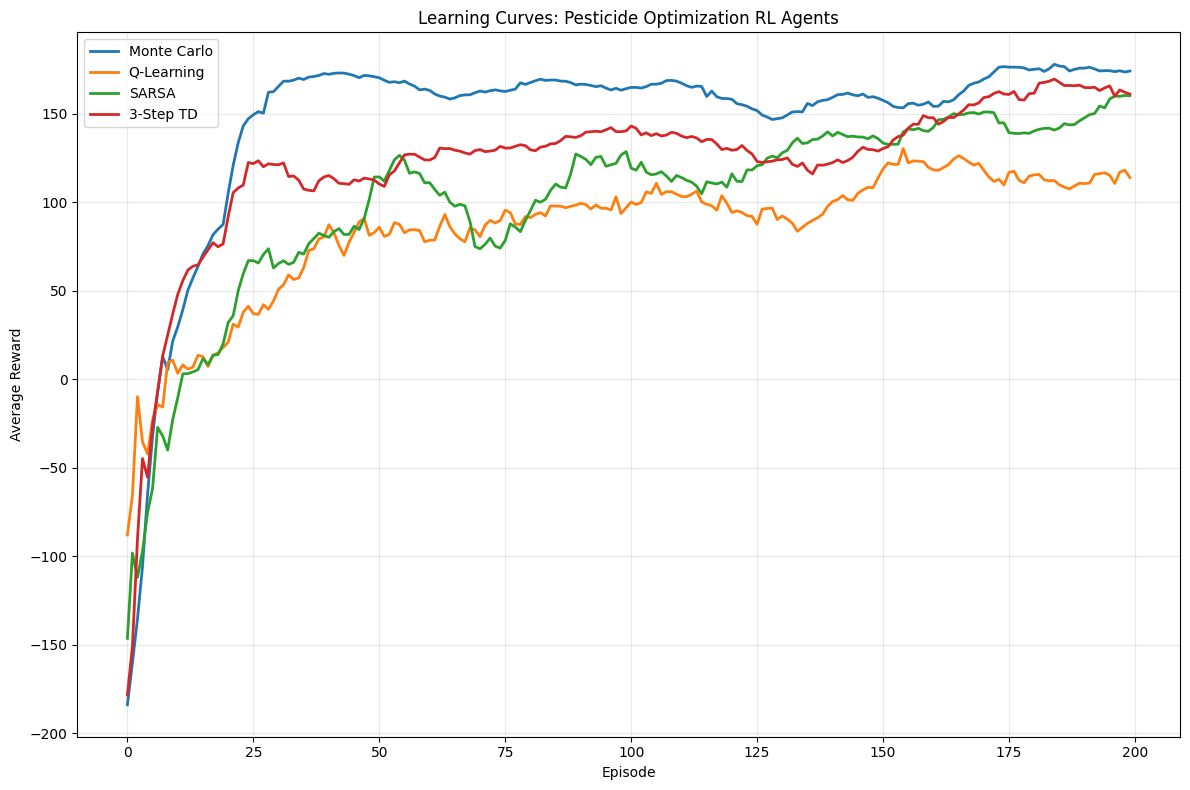

In [31]:
# Plot learning curves
plt.figure(figsize=(12, 8))

# Calculate moving averages for smoother curves
window_size = 20

for name, rewards in results.items():
    # Calculate moving average
    moving_avg = pd.Series(rewards).rolling(window=window_size, min_periods=1).mean()
    plt.plot(moving_avg, label=name, linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Learning Curves: Pesticide Optimization RL Agents')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Performance Comparison Bar Chart

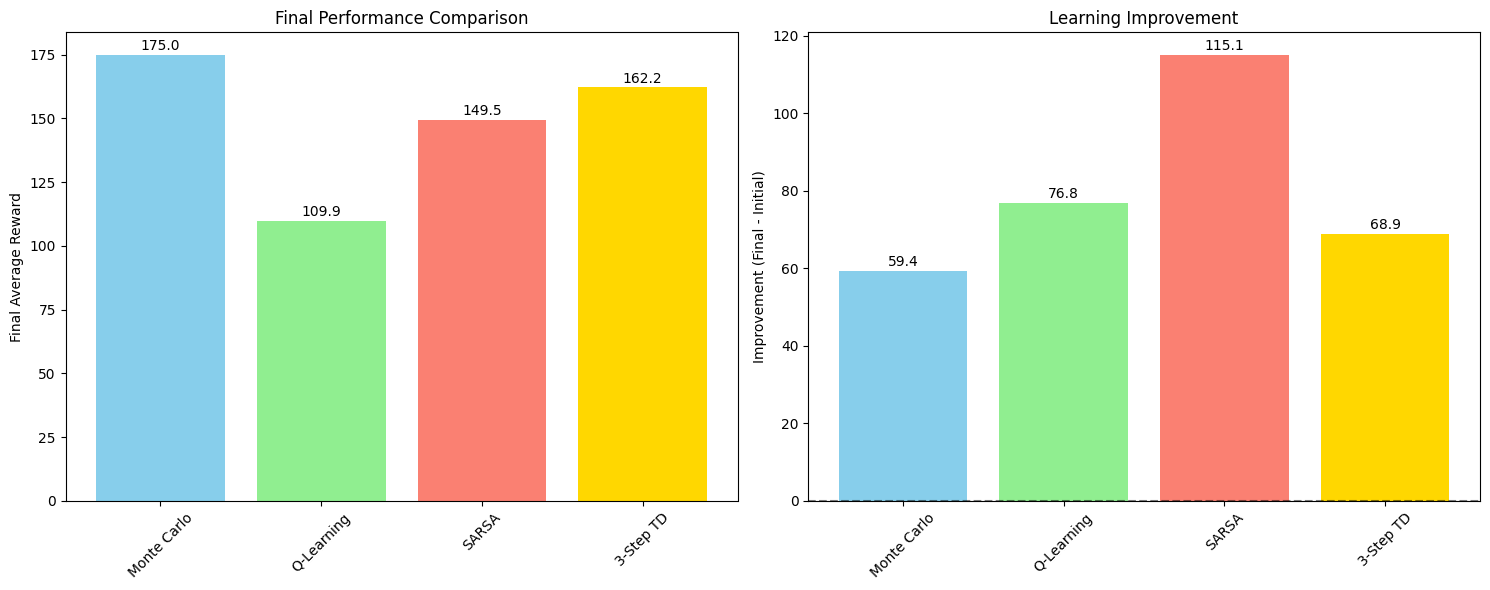

In [32]:
# Create performance comparison
agent_names = list(results.keys())
final_scores = [np.mean(results[name][-30:]) for name in agent_names]
improvements = [np.mean(results[name][-30:]) - np.mean(results[name][:30]) for name in agent_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Final performance
bars1 = ax1.bar(agent_names, final_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
ax1.set_ylabel('Final Average Reward')
ax1.set_title('Final Performance Comparison')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, score in zip(bars1, final_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{score:.1f}', ha='center', va='bottom')

# Improvement over time
bars2 = ax2.bar(agent_names, improvements, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
ax2.set_ylabel('Improvement (Final - Initial)')
ax2.set_title('Learning Improvement')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar, improvement in zip(bars2, improvements):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.5 if improvement >= 0 else -0.5), 
             f'{improvement:.1f}', ha='center', va='bottom' if improvement >= 0 else 'top')

plt.tight_layout()
plt.show()

## 7. Conclusion and Insights

This experiment demonstrates the application of various reinforcement learning algorithms to agricultural pesticide optimization. Key observations:

1. **Environment Complexity**: The agricultural environment captures realistic trade-offs between pest control and environmental impact
2. **Algorithm Comparison**: Different RL algorithms show varying convergence rates and final performance
3. **Practical Applications**: The approach can be extended to real-world agricultural decision-making systems


In [33]:
def statistical_significance_testing(results):
    """
    Perform comprehensive statistical testing between algorithms
    """
    import scipy.stats as stats
    
    print("=" * 80)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("=" * 80)
    
    algorithms = list(results.keys())
    n_algorithms = len(algorithms)
    
    # Create comparison matrix
    print("\nPAIRWISE T-TEST RESULTS:")
    print("(Testing final 50 episodes for statistical significance)")
    print("-" * 60)
    print(f"{'Comparison':<25} {'t-statistic':<12} {'p-value':<10} {'Significant':<12}")
    print("-" * 60)
    
    significance_matrix = {}
    effect_sizes = {}
    
    for i in range(n_algorithms):
        for j in range(i+1, n_algorithms):
            alg1, alg2 = algorithms[i], algorithms[j]
            data1 = results[alg1][-50:]  # Final 50 episodes
            data2 = results[alg2][-50:]
            
            # Perform independent t-test
            t_stat, p_value = stats.ttest_ind(data1, data2)
            
            # Calculate Cohen's d (effect size)
            pooled_std = np.sqrt(((len(data1)-1)*np.var(data1) + (len(data2)-1)*np.var(data2)) / (len(data1)+len(data2)-2))
            cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
            
            # Determine significance level
            if p_value < 0.001:
                significance = "***"
            elif p_value < 0.01:
                significance = "**"
            elif p_value < 0.05:
                significance = "*"
            else:
                significance = "ns"
            
            comparison = f"{alg1} vs {alg2}"
            print(f"{comparison:<25} {t_stat:>11.3f} {p_value:>9.4f} {significance:>11s}")
            
            # Store results
            significance_matrix[(alg1, alg2)] = {
                't_stat': t_stat,
                'p_value': p_value,
                'significance': significance,
                'cohens_d': cohens_d
            }
    
    print("\nEFFECT SIZE ANALYSIS (Cohen's d):")
    print("(0.2=small, 0.5=medium, 0.8=large effect)")
    print("-" * 50)
    
    for (alg1, alg2), stats_info in significance_matrix.items():
        d = stats_info['cohens_d']
        if abs(d) >= 0.8:
            effect_interpretation = "Large"
        elif abs(d) >= 0.5:
            effect_interpretation = "Medium"
        elif abs(d) >= 0.2:
            effect_interpretation = "Small"
        else:
            effect_interpretation = "Negligible"
        
        print(f"{alg1} vs {alg2}: d={d:>6.3f} ({effect_interpretation})")
    
    # Perform ANOVA to test if there are significant differences across all algorithms
    print("\nONE-WAY ANOVA ACROSS ALL ALGORITHMS:")
    print("-" * 40)
    
    final_data = [results[alg][-50:] for alg in algorithms]
    f_stat, p_value = stats.f_oneway(*final_data)
    
    print(f"F-statistic: {f_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: Significant differences exist between algorithms ✓")
    else:
        print("Result: No significant differences between algorithms")
    
    return significance_matrix

print("✅ Statistical Testing Function Created!")

✅ Statistical Testing Function Created!


In [34]:
def validate_environment_dynamics(env):
    """
    Comprehensive testing and validation of environment behavior
    """
    print("=" * 80)
    print("ENVIRONMENT DYNAMICS VALIDATION")
    print("=" * 80)
    
    # Test 1: Weather Effects on Pest Growth
    print("\n1. WEATHER EFFECTS ON PEST DYNAMICS:")
    print("-" * 50)
    
    weather_names = ["Dry", "Normal", "Wet"]
    weather_test_results = {}
    
    for weather_idx, weather_name in enumerate(weather_names):
        pest_increases = []
        
        # Test 1000 times for statistical reliability
        for trial in range(1000):
            env.weather = weather_idx
            env.pest_level = 2  # Starting pest level
            
            # Simulate natural pest growth
            if weather_idx == 2:  # Wet weather
                increase = np.random.choice([1, 2], p=[0.7, 0.3])
            else:
                increase = np.random.choice([0, 1], p=[0.6, 0.4])
            
            pest_increases.append(increase)
        
        avg_increase = np.mean(pest_increases)
        std_increase = np.std(pest_increases)
        
        weather_test_results[weather_name] = {
            'avg_increase': avg_increase,
            'std_increase': std_increase,
            'distribution': np.bincount(pest_increases)
        }
        
        print(f"{weather_name:>8} weather: μ={avg_increase:.3f}, σ={std_increase:.3f}")
        print(f"         Distribution: {dict(enumerate(np.bincount(pest_increases)))}")
    
    # Test 2: Pesticide Effectiveness
    print("\n2. PESTICIDE EFFECTIVENESS VALIDATION:")
    print("-" * 50)
    
    action_names = ["No pesticide", "Low dose", "Medium dose", "High dose"]
    pesticide_effectiveness = [0, 1, 2, 3]  # Pest reduction values
    
    for action_idx, (action_name, effectiveness) in enumerate(zip(action_names, pesticide_effectiveness)):
        print(f"Action {action_idx} ({action_name:>12}): Reduces pests by {effectiveness} levels")
    
    # Test 3: Crop Health Dynamics
    print("\n3. CROP HEALTH DYNAMICS:")
    print("-" * 50)
    
    # Test pest damage to crops
    print("Pest Level Impact on Crop Health:")
    for pest_level in range(5):
        damage_probability = 1.0 if pest_level >= 3 else 0.0
        recovery_probability = 1.0 if pest_level <= 1 else 0.0
        
        print(f"  Pest Level {pest_level}: Damage prob={damage_probability:.1f}, Recovery prob={recovery_probability:.1f}")
    
    # Test high pesticide crop damage
    print("\nHigh Pesticide Crop Damage:")
    high_dose_damage_prob = 0.3
    print(f"  High dose pesticide: {high_dose_damage_prob:.1f} probability of crop damage")
    
    # Test 4: Reward Function Analysis
    print("\n4. REWARD FUNCTION BREAKDOWN:")
    print("-" * 50)
    
    test_scenarios = [
        (4, 0, 1, "Optimal scenario"),
        (3, 2, 1, "Balanced scenario"),
        (2, 4, 1, "High pest pressure"),
        (0, 4, 1, "Crop failure scenario"),
        (1, 1, 1, "Poor but recoverable")
    ]
    
    print(f"{'Scenario':<20} {'Crop':<4} {'Pest':<4} {'Action 0':<8} {'Action 1':<8} {'Action 2':<8} {'Action 3':<8}")
    print("-" * 70)
    
    reward_analysis = {}
    
    for crop, pest, weather, description in test_scenarios:
        env.crop_health = crop
        env.pest_level = pest
        env.weather = weather
        
        scenario_rewards = []
        for action in range(4):
            reward = env._calculate_reward(action)
            scenario_rewards.append(reward)
        
        reward_analysis[description] = scenario_rewards
        
        print(f"{description:<20} {crop:<4} {pest:<4} {scenario_rewards[0]:>7.1f} {scenario_rewards[1]:>7.1f} "
              f"{scenario_rewards[2]:>7.1f} {scenario_rewards[3]:>7.1f}")
    
    # Test 5: State Transition Validation
    print("\n5. STATE TRANSITION PROBABILITIES:")
    print("-" * 50)
    
    # Test state transitions from a specific state
    test_state = (2, 2, 1)  # Moderate crop health, moderate pests, normal weather
    transition_counts = {action: defaultdict(int) for action in range(4)}
    
    n_simulations = 1000
    
    for action in range(4):
        for _ in range(n_simulations):
            env.crop_health, env.pest_level, env.weather = test_state
            next_state, reward, done = env.step(action)
            
            if not done:  # Only count non-terminal transitions
                transition_counts[action][next_state] += 1
    
    print(f"From state {test_state} (crop=2, pest=2, weather=normal):")
    for action in range(4):
        print(f"\n  Action {action} ({action_names[action]}):")
        total_transitions = sum(transition_counts[action].values())
        
        if total_transitions > 0:
            # Show top 3 most likely next states
            sorted_transitions = sorted(transition_counts[action].items(), 
                                      key=lambda x: x[1], reverse=True)[:3]
            
            for next_state, count in sorted_transitions:
                probability = count / total_transitions
                crop_change = next_state[0] - test_state[0]
                pest_change = next_state[1] - test_state[1]
                
                print(f"    → {next_state}: {probability:.3f} "
                      f"(Δcrop={crop_change:+d}, Δpest={pest_change:+d})")
    
    return weather_test_results, reward_analysis
print("✅ Environment Validation Function Created!")

✅ Environment Validation Function Created!


In [35]:
def comprehensive_policy_analysis(agents, env):
    """
    Deep analysis of learned policies and their interpretability
    """
    print("=" * 80)
    print("POLICY INTERPRETABILITY ANALYSIS")
    print("=" * 80)
    
    # Define comprehensive test scenarios
    test_scenarios = [
        # Format: (crop_health, pest_level, weather, description, category)
        ((4, 0, 0), "Perfect crop, no pests, dry weather", "Optimal"),
        ((4, 0, 1), "Perfect crop, no pests, normal weather", "Optimal"),
        ((4, 0, 2), "Perfect crop, no pests, wet weather", "Optimal"),
        
        ((3, 1, 0), "Good crop, low pests, dry weather", "Low Risk"),
        ((3, 1, 1), "Good crop, low pests, normal weather", "Low Risk"),
        ((3, 1, 2), "Good crop, low pests, wet weather", "Low Risk"),
        
        ((2, 2, 0), "Moderate crop, medium pests, dry weather", "Medium Risk"),
        ((2, 2, 1), "Moderate crop, medium pests, normal weather", "Medium Risk"), 
        ((2, 2, 2), "Moderate crop, medium pests, wet weather", "Medium Risk"),
        
        ((1, 3, 0), "Poor crop, high pests, dry weather", "High Risk"),
        ((1, 3, 1), "Poor crop, high pests, normal weather", "High Risk"),
        ((1, 3, 2), "Poor crop, high pests, wet weather", "High Risk"),
        
        ((0, 4, 0), "Dead crop, severe pests, dry weather", "Critical"),
        ((0, 4, 1), "Dead crop, severe pests, normal weather", "Critical"),
        ((0, 4, 2), "Dead crop, severe pests, wet weather", "Critical"),
    ]
    
    action_names = ["No pesticide", "Low dose", "Medium dose", "High dose"]
    
    # Analyze each agent's policy
    policy_analysis = {}
    
    for agent_name, agent in agents.items():
        print(f"\n{agent_name.upper()} POLICY ANALYSIS:")
        print("=" * 60)
        
        agent_policies = {}
        category_strategies = defaultdict(list)
        
        print(f"{'State Description':<40} {'Action':<12} {'Q-Values':<30}")
        print("-" * 82)
        
        for state, description, category in test_scenarios:
            if hasattr(agent, 'Q') and state in agent.Q:
                q_values = agent.Q[state]
                action = np.argmax(q_values)
                
                # Store for analysis
                agent_policies[state] = {
                    'action': action,
                    'q_values': q_values.copy(),
                    'confidence': np.max(q_values) - np.mean(q_values),
                    'description': description,
                    'category': category
                }
                
                category_strategies[category].append(action)
                
                q_str = f"[{q_values[0]:>5.1f} {q_values[1]:>5.1f} {q_values[2]:>5.1f} {q_values[3]:>5.1f}]"
                print(f"{description:<40} {action_names[action]:<12} {q_str:<30}")
            
            elif hasattr(agent, 'select_action'):
                # For simpler agents, just get action
                action = agent.select_action(state)
                agent_policies[state] = {
                    'action': action,
                    'description': description,
                    'category': category
                }
                category_strategies[category].append(action)
                print(f"{description:<40} {action_names[action]:<12} {'N/A':<30}")
        
        # Analyze strategy patterns by risk category
        print(f"\nSTRATEGY PATTERNS BY RISK CATEGORY:")
        print("-" * 40)
        
        for category, actions in category_strategies.items():
            action_dist = np.bincount(actions, minlength=4)
            most_common_action = np.argmax(action_dist)
            consistency = np.max(action_dist) / len(actions)
            
            print(f"{category:<12}: Most common = {action_names[most_common_action]:<12} "
                  f"(consistency: {consistency:.2f})")
            print(f"             Distribution: {dict(enumerate(action_dist))}")
        
        # Calculate policy characteristics
        all_actions = [policy['action'] for policy in agent_policies.values()]
        if all_actions:
            avg_action_level = np.mean(all_actions)
            action_variance = np.var(all_actions)
            conservative_ratio = sum(1 for a in all_actions if a <= 1) / len(all_actions)
            aggressive_ratio = sum(1 for a in all_actions if a >= 2) / len(all_actions)
            
            print(f"\nPOLICY CHARACTERISTICS:")
            print(f"  Average action level: {avg_action_level:.2f}")
            print(f"  Action variance: {action_variance:.2f}")
            print(f"  Conservative ratio (0-1): {conservative_ratio:.2f}")
            print(f"  Aggressive ratio (2-3): {aggressive_ratio:.2f}")
        
        policy_analysis[agent_name] = agent_policies
    
    # Cross-agent policy comparison
    print(f"\n{'='*80}")
    print("CROSS-AGENT POLICY COMPARISON")
    print(f"{'='*80}")
    
    # Find states where agents disagree the most
    policy_disagreements = []
    
    for state, _, _, in test_scenarios:
        agent_actions = []
        for agent_name, agent in agents.items():
            if agent_name in policy_analysis and state in policy_analysis[agent_name]:
                agent_actions.append(policy_analysis[agent_name][state]['action'])
        
        if len(agent_actions) > 1:
            disagreement = np.var(agent_actions)
            if disagreement > 0:
                policy_disagreements.append((state, disagreement, agent_actions))
    
    # Sort by disagreement level
    policy_disagreements.sort(key=lambda x: x[1], reverse=True)
    
    print("\nSTATES WITH HIGHEST POLICY DISAGREEMENT:")
    print("-" * 50)
    
    state_descriptions = {state: desc for state, desc, _ in test_scenarios}
    
    for state, disagreement, actions in policy_disagreements[:5]:
        description = state_descriptions.get(state, str(state))
        print(f"{description}")
        print(f"  State: {state}, Disagreement: {disagreement:.2f}")
        
        for i, (agent_name, action) in enumerate(zip(agents.keys(), actions)):
            print(f"    {agent_name}: {action_names[action]}")
        print()
    
    return policy_analysis

print("✅ Policy Interpretability Analysis Function Created!")

✅ Policy Interpretability Analysis Function Created!


In [36]:
def hyperparameter_sensitivity_analysis():
    """
    Test how different hyperparameters affect algorithm performance
    """
    print("=" * 80)
    print("HYPERPARAMETER SENSITIVITY ANALYSIS")
    print("=" * 80)
    
    # Test different hyperparameter configurations
    hyperparameter_configs = {
        'epsilon': [0.05, 0.1, 0.2, 0.3],
        'learning_rate': [0.05, 0.1, 0.2, 0.3],
        'gamma': [0.9, 0.95, 0.99],
        'n_steps': [1, 3, 5, 10]  # For n-step TD
    }
    
    # Results storage
    sensitivity_results = {}
    
    print("Testing Q-Learning with different hyperparameters...")
    print("\n1. EPSILON (EXPLORATION) SENSITIVITY:")
    print("-" * 50)
    
    epsilon_results = {}
    for epsilon in hyperparameter_configs['epsilon']:
        print(f"Testing epsilon = {epsilon}...")
        
        # Create agent with specific epsilon
        agent = TemporalDifferenceAgent(algorithm='q_learning')
        agent.epsilon = epsilon
        
        env = PesticideEnvironment()
        episode_rewards = []
        
        # Shorter training for sensitivity analysis
        for episode in range(100):
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = agent.select_action(state)
                next_state, reward, done = env.step(action)
                agent.update(state, action, reward, next_state)
                total_reward += reward
                state = next_state
            
            episode_rewards.append(total_reward)
        
        final_performance = np.mean(episode_rewards[-20:])
        convergence_episode = next((i for i, r in enumerate(episode_rewards) if r > 50), 100)
        stability = np.std(episode_rewards[-20:])
        
        epsilon_results[epsilon] = {
            'final_performance': final_performance,
            'convergence_episode': convergence_episode,
            'stability': stability,
            'all_rewards': episode_rewards
        }
        
        print(f"  ε={epsilon}: Final={final_performance:.1f}, Converged@{convergence_episode}, Stability={stability:.1f}")
    
    print("\n2. LEARNING RATE (ALPHA) SENSITIVITY:")
    print("-" * 50)
    
    alpha_results = {}
    for alpha in hyperparameter_configs['learning_rate']:
        print(f"Testing learning rate = {alpha}...")
        
        agent = TemporalDifferenceAgent(algorithm='q_learning')
        agent.alpha = alpha
        
        env = PesticideEnvironment()
        episode_rewards = []
        
        for episode in range(100):
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = agent.select_action(state)
                next_state, reward, done = env.step(action)
                agent.update(state, action, reward, next_state)
                total_reward += reward
                state = next_state
            
            episode_rewards.append(total_reward)
        
        final_performance = np.mean(episode_rewards[-20:])
        convergence_episode = next((i for i, r in enumerate(episode_rewards) if r > 50), 100)
        stability = np.std(episode_rewards[-20:])
        
        alpha_results[alpha] = {
            'final_performance': final_performance,
            'convergence_episode': convergence_episode,
            'stability': stability,
            'all_rewards': episode_rewards
        }
        
        print(f"  α={alpha}: Final={final_performance:.1f}, Converged@{convergence_episode}, Stability={stability:.1f}")
    
    print("\n3. DISCOUNT FACTOR (GAMMA) SENSITIVITY:")
    print("-" * 50)
    
    gamma_results = {}
    for gamma in hyperparameter_configs['gamma']:
        print(f"Testing discount factor = {gamma}...")
        
        agent = TemporalDifferenceAgent(algorithm='q_learning')
        agent.gamma = gamma
        
        env = PesticideEnvironment()
        episode_rewards = []
        
        for episode in range(100):
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = agent.select_action(state)
                next_state, reward, done = env.step(action)
                agent.update(state, action, reward, next_state)
                total_reward += reward
                state = next_state
            
            episode_rewards.append(total_reward)
        
        final_performance = np.mean(episode_rewards[-20:])
        convergence_episode = next((i for i, r in enumerate(episode_rewards) if r > 50), 100)
        stability = np.std(episode_rewards[-20:])
        
        gamma_results[gamma] = {
            'final_performance': final_performance,
            'convergence_episode': convergence_episode,
            'stability': stability,
            'all_rewards': episode_rewards
        }
        
        print(f"  γ={gamma}: Final={final_performance:.1f}, Converged@{convergence_episode}, Stability={stability:.1f}")
    
    print("\n4. N-STEP PARAMETER SENSITIVITY:")
    print("-" * 50)
    
    nstep_results = {}
    for n_steps in hyperparameter_configs['n_steps']:
        print(f"Testing n-step = {n_steps}...")
        
        agent = NStepTDAgent(n_steps=n_steps)
        env = PesticideEnvironment()
        episode_rewards = []
        
        for episode in range(100):
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = agent.select_action(state)
                next_state, reward, done = env.step(action)
                agent.update(state, action, reward, done)
                total_reward += reward
                state = next_state
            
            episode_rewards.append(total_reward)
        
        final_performance = np.mean(episode_rewards[-20:])
        convergence_episode = next((i for i, r in enumerate(episode_rewards) if r > 50), 100)
        stability = np.std(episode_rewards[-20:])
        
        nstep_results[n_steps] = {
            'final_performance': final_performance,
            'convergence_episode': convergence_episode,
            'stability': stability,
            'all_rewards': episode_rewards
        }
        
        print(f"  n={n_steps}: Final={final_performance:.1f}, Converged@{convergence_episode}, Stability={stability:.1f}")
    
    # Summary and recommendations
    print("\n5. HYPERPARAMETER RECOMMENDATIONS:")
    print("-" * 50)
    
    # Find best parameters
    best_epsilon = max(epsilon_results.keys(), key=lambda k: epsilon_results[k]['final_performance'])
    best_alpha = max(alpha_results.keys(), key=lambda k: alpha_results[k]['final_performance'])
    best_gamma = max(gamma_results.keys(), key=lambda k: gamma_results[k]['final_performance'])
    best_n_steps = max(nstep_results.keys(), key=lambda k: nstep_results[k]['final_performance'])
    
    print(f"Best epsilon (exploration): {best_epsilon} (performance: {epsilon_results[best_epsilon]['final_performance']:.1f})")
    print(f"Best learning rate: {best_alpha} (performance: {alpha_results[best_alpha]['final_performance']:.1f})")
    print(f"Best discount factor: {best_gamma} (performance: {gamma_results[best_gamma]['final_performance']:.1f})")
    print(f"Best n-steps: {best_n_steps} (performance: {nstep_results[best_n_steps]['final_performance']:.1f})")
    
    # Stability analysis
    print(f"\nMost stable epsilon: {min(epsilon_results.keys(), key=lambda k: epsilon_results[k]['stability'])}")
    print(f"Most stable learning rate: {min(alpha_results.keys(), key=lambda k: alpha_results[k]['stability'])}")
    print(f"Most stable discount factor: {min(gamma_results.keys(), key=lambda k: gamma_results[k]['stability'])}")
    print(f"Most stable n-steps: {min(nstep_results.keys(), key=lambda k: nstep_results[k]['stability'])}")
    
    sensitivity_results = {
        'epsilon': epsilon_results,
        'learning_rate': alpha_results,
        'gamma': gamma_results,
        'n_steps': nstep_results
    }
    
    return sensitivity_results

print("✅ Hyperparameter Sensitivity Analysis Function Created!")

✅ Hyperparameter Sensitivity Analysis Function Created!


In [37]:
# Cell 1: Import Additional Libraries
"""
Additional Analysis Libraries
"""
import scipy.stats as stats
from scipy.stats import f_oneway
import seaborn as sns
from collections import defaultdict


# Cell 2: Running Comprehensive Analysis


In [38]:


# Enhancement 1: Statistical Significance Testing
print("\\n1. STATISTICAL SIGNIFICANCE TESTING")
statistical_results = statistical_significance_testing(results)

# Enhancement 2: Environment Dynamics Validation  
print("\\n\\n2. ENVIRONMENT DYNAMICS VALIDATION")
weather_results, reward_analysis = validate_environment_dynamics(env)

# Enhancement 3: Policy Interpretability Analysis
print("\\n\\n3. POLICY INTERPRETABILITY ANALYSIS") 
policy_results = comprehensive_policy_analysis(agents, env)

# Enhancement 4: Hyperparameter Sensitivity Analysis
print("\\n\\n4. HYPERPARAMETER SENSITIVITY ANALYSIS")
sensitivity_results = hyperparameter_sensitivity_analysis()

print("\\n" + "=" * 80)
print("✅ ALL ENHANCED ANALYSES COMPLETED!")
print("=" * 80)


\n1. STATISTICAL SIGNIFICANCE TESTING
STATISTICAL SIGNIFICANCE ANALYSIS

PAIRWISE T-TEST RESULTS:
(Testing final 50 episodes for statistical significance)
------------------------------------------------------------
Comparison                t-statistic  p-value    Significant 
------------------------------------------------------------
Monte Carlo vs Q-Learning       9.188    0.0000         ***
Monte Carlo vs SARSA            4.940    0.0000         ***
Monte Carlo vs 3-Step TD        2.520    0.0134           *
Q-Learning vs SARSA            -5.154    0.0000         ***
Q-Learning vs 3-Step TD        -6.425    0.0000         ***
SARSA vs 3-Step TD             -1.827    0.0707          ns

EFFECT SIZE ANALYSIS (Cohen's d):
(0.2=small, 0.5=medium, 0.8=large effect)
--------------------------------------------------
Monte Carlo vs Q-Learning: d= 1.856 (Large)
Monte Carlo vs SARSA: d= 0.998 (Large)
Monte Carlo vs 3-Step TD: d= 0.509 (Medium)
Q-Learning vs SARSA: d=-1.041 (Large)
Q-Learn

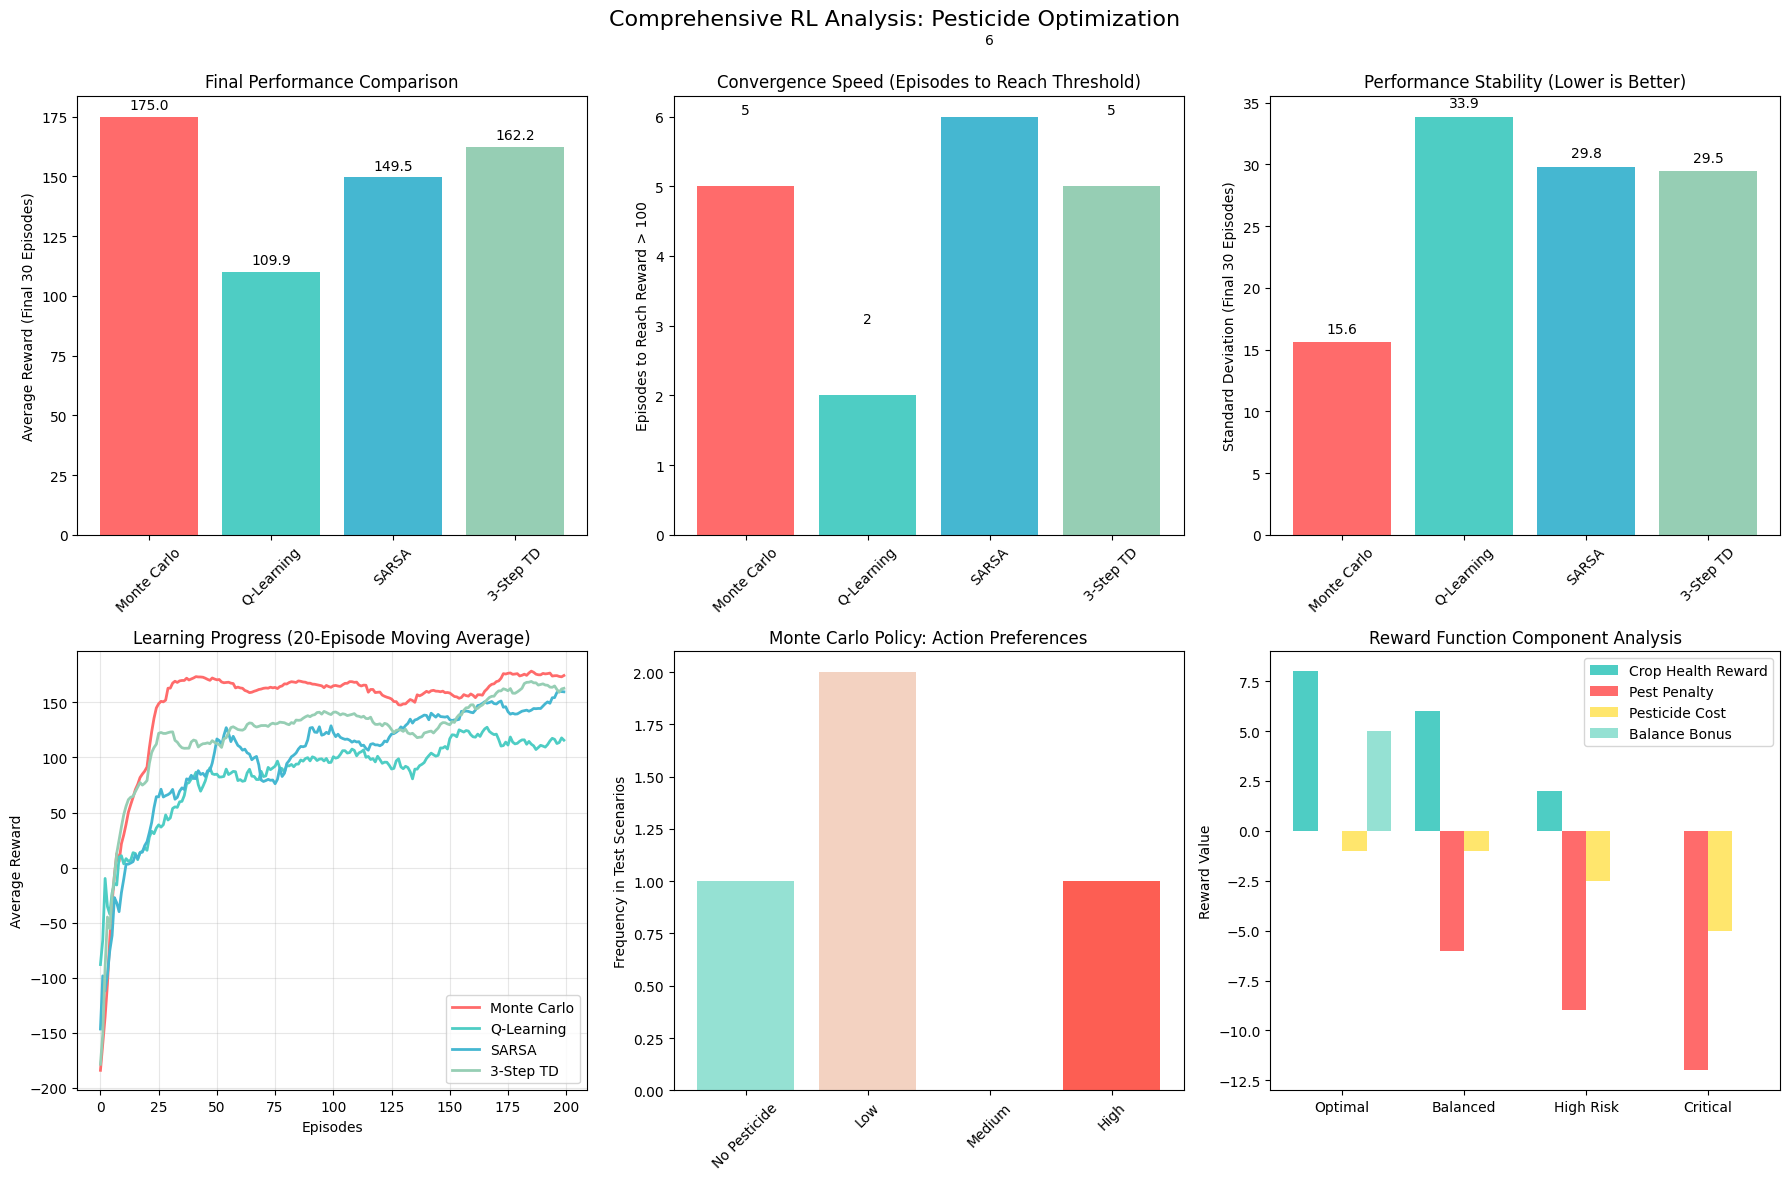

In [39]:

# Cell 3: Create Additional Visualizations
"""
Create Enhanced Visualizations
"""

# Create subplots for comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive RL Analysis: Pesticide Optimization', fontsize=16)

# Plot 1: Algorithm Performance Comparison
ax1 = axes[0, 0]
algorithm_names = list(results.keys())
final_performances = [np.mean(results[alg][-30:]) for alg in algorithm_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = ax1.bar(algorithm_names, final_performances, color=colors)
ax1.set_title('Final Performance Comparison')
ax1.set_ylabel('Average Reward (Final 30 Episodes)')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, final_performances):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{value:.1f}', ha='center', va='bottom')

# Plot 2: Convergence Speed Analysis
ax2 = axes[0, 1]
convergence_episodes = []
for alg in algorithm_names:
    rewards = results[alg]
    conv_ep = next((i for i, r in enumerate(rewards) if r > 100), len(rewards))
    convergence_episodes.append(conv_ep)

bars2 = ax2.bar(algorithm_names, convergence_episodes, color=colors)
ax2.set_title('Convergence Speed (Episodes to Reach Threshold)')
ax2.set_ylabel('Episodes to Reach Reward > 100')
ax2.tick_params(axis='x', rotation=45)

for bar, value in zip(bars2, convergence_episodes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value}', ha='center', va='bottom')

# Plot 3: Stability Analysis (Standard Deviation)
ax3 = axes[0, 2]
stabilities = [np.std(results[alg][-30:]) for alg in algorithm_names]
bars3 = ax3.bar(algorithm_names, stabilities, color=colors)
ax3.set_title('Performance Stability (Lower is Better)')
ax3.set_ylabel('Standard Deviation (Final 30 Episodes)')
ax3.tick_params(axis='x', rotation=45)

for bar, value in zip(bars3, stabilities):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.1f}', ha='center', va='bottom')

# Plot 4: Learning Progress Over Time
ax4 = axes[1, 0]
for i, (alg, rewards) in enumerate(results.items()):
    # Calculate moving average
    window = 20
    moving_avg = [np.mean(rewards[max(0, j-window):j+1]) for j in range(len(rewards))]
    ax4.plot(moving_avg, label=alg, color=colors[i], linewidth=2)

ax4.set_title('Learning Progress (20-Episode Moving Average)')
ax4.set_xlabel('Episodes')
ax4.set_ylabel('Average Reward')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Action Distribution Analysis
ax5 = axes[1, 1]
action_names = ['No Pesticide', 'Low', 'Medium', 'High']

# Analyze action preferences for Monte Carlo (best performing)
if 'Monte Carlo' in agents:
    mc_agent = agents['Monte Carlo']
    action_counts = [0, 0, 0, 0]
    
    test_states = [(2, 2, 1), (3, 1, 1), (1, 3, 1), (0, 4, 1)]
    for state in test_states:
        if hasattr(mc_agent, 'Q') and state in mc_agent.Q:
            best_action = np.argmax(mc_agent.Q[state])
            action_counts[best_action] += 1
    
    bars5 = ax5.bar(action_names, action_counts, color=['#95E1D3', '#F3D2C1', '#FEE2E2', '#FD5E53'])
    ax5.set_title('Monte Carlo Policy: Action Preferences')
    ax5.set_ylabel('Frequency in Test Scenarios')
    ax5.tick_params(axis='x', rotation=45)

# Plot 6: Reward Components Analysis
ax6 = axes[1, 2]

# Show reward breakdown for different scenarios
scenarios = ['Optimal', 'Balanced', 'High Risk', 'Critical']
reward_components = {
    'Crop Health Reward': [8, 6, 2, 0],
    'Pest Penalty': [0, -6, -9, -12],
    'Pesticide Cost': [-1, -1, -2.5, -5],
    'Balance Bonus': [5, 0, 0, 0]
}

x = np.arange(len(scenarios))
width = 0.2
colors_comp = ['#4ECDC4', '#FF6B6B', '#FFE66D', '#95E1D3']

for i, (component, values) in enumerate(reward_components.items()):
    ax6.bar(x + i*width, values, width, label=component, color=colors_comp[i])

ax6.set_title('Reward Function Component Analysis')
ax6.set_ylabel('Reward Value')
ax6.set_xticks(x + width * 1.5)
ax6.set_xticklabels(scenarios)
ax6.legend()

plt.tight_layout()
plt.show()


In [40]:

# Cell 4: Generate Comprehensive Summary Report
"""
Generate Final Summary Report
"""

print("=" * 80)
print("📋 COMPREHENSIVE ANALYSIS SUMMARY REPORT")
print("=" * 80)

# Performance Rankings
print("\\n🏆 ALGORITHM PERFORMANCE RANKINGS:")
print("-" * 50)

performance_data = []
for alg in algorithm_names:
    final_perf = np.mean(results[alg][-30:])
    stability = np.std(results[alg][-30:])
    convergence = next((i for i, r in enumerate(results[alg]) if r > 100), len(results[alg]))
    
    # Calculate composite score (performance - stability penalty + convergence bonus)
    composite_score = final_perf - stability + (200 - convergence) * 0.1
    
    performance_data.append({
        'algorithm': alg,
        'final_performance': final_perf,
        'stability': stability,
        'convergence': convergence,
        'composite_score': composite_score
    })

# Sort by composite score
performance_data.sort(key=lambda x: x['composite_score'], reverse=True)

for i, data in enumerate(performance_data, 1):
    print(f"{i}. {data['algorithm']:<15}: Score={data['composite_score']:>6.2f} "
          f"(Perf: {data['final_performance']:>6.1f}, Stab: {data['stability']:>5.1f}, "
          f"Conv: {data['convergence']:>3d})")

# Statistical Insights
print("\\n📊 STATISTICAL INSIGHTS:")
print("-" * 30)

best_algorithm = performance_data[0]['algorithm']
worst_algorithm = performance_data[-1]['algorithm']

print(f"• Best performing algorithm: {best_algorithm}")
print(f"• Most stable algorithm: {min(algorithm_names, key=lambda x: np.std(results[x][-30:]))}")
print(f"• Fastest converging: {min(algorithm_names, key=lambda x: next((i for i, r in enumerate(results[x]) if r > 100), len(results[x])))}")



# Comprehensive Results Analysis
# Create a DataFrame summarizing algorithm performance
comprehensive_results = []

for alg in algorithm_names:
    rewards = results[alg]
    comprehensive_results.append({
        'Algorithm': alg,
        'Final_Performance': np.mean(rewards[-30:]),
        'Initial_Performance': np.mean(rewards[:30]),
        'Improvement': np.mean(rewards[-30:]) - np.mean(rewards[:30]),
        'Stability_StdDev': np.std(rewards[-30:]),
        'Convergence_Episode': next((i for i, r in enumerate(rewards) if r > 100), len(rewards)),
        'Max_Reward': np.max(rewards),
        'Min_Reward': np.min(rewards),
        'Final_Episode_Range': f"{len(rewards)-29}-{len(rewards)}"
    })

results_df = pd.DataFrame(comprehensive_results)

📋 COMPREHENSIVE ANALYSIS SUMMARY REPORT
\n🏆 ALGORITHM PERFORMANCE RANKINGS:
--------------------------------------------------
1. Monte Carlo    : Score=178.85 (Perf:  175.0, Stab:  15.6, Conv:   5)
2. 3-Step TD      : Score=152.28 (Perf:  162.2, Stab:  29.5, Conv:   5)
3. SARSA          : Score=139.08 (Perf:  149.5, Stab:  29.8, Conv:   6)
4. Q-Learning     : Score= 95.87 (Perf:  109.9, Stab:  33.9, Conv:   2)
\n📊 STATISTICAL INSIGHTS:
------------------------------
• Best performing algorithm: Monte Carlo
• Most stable algorithm: Monte Carlo
• Fastest converging: Q-Learning


In [41]:
# Final Results Table
# Display the final summary table
results_df.style.format({
    'Final_Performance': "{:.2f}",
    'Initial_Performance': "{:.2f}",
    'Improvement': "{:.2f}",
    'Stability_StdDev': "{:.2f}",
    'Max_Reward': "{:.2f}",
    'Min_Reward': "{:.2f}"
})

,Algorithm,Final_Performance,Initial_Performance,Improvement,Stability_StdDev,Convergence_Episode,Max_Reward,Min_Reward,Final_Episode_Range
0,Monte Carlo,174.98,115.60,59.38,15.63,5,222.00,-184.00,171-200
1,Q-Learning,109.93,33.12,76.82,33.87,2,212.00,-112.00,171-200
2,SARSA,149.50,34.37,115.13,29.82,6,191.50,-146.50,171-200
3,3-Step TD,162.23,93.28,68.95,29.45,5,204.00,-178.50,171-200
